In [1]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image

np.set_printoptions(suppress=True, precision=2)

In [2]:
from data_processing.Processor import load_detection_ds, Processor
from matplotlib import cm as mp_cm
import cv2
import tqdm

In [3]:
from data_processing import image, bboxes
from utils.draw_bboxes import draw_bboxes
from models.fcos import build
from data_processing.io import load_gmc

In [4]:
raw_ds = load_detection_ds("training/val_dataset.yaml")

for sample in raw_ds:
    break

In [5]:
processor = Processor([
    image.LoadImage(),
    bboxes.LoadBboxes(n_bboxes=90),
    image.ResizeKeepRatio(300,400),
    image.Normalize(),
    bboxes.BuildFCOSTarget((300,400), [8])
], feature_keys=None)

processed_ds = raw_ds.map(processor)

In [6]:
model = build.build_model()

# Detection Report

In [7]:
model.load_weights('models/fcos/snapshots/colab_weights_v2.hdf5')

In [8]:
from models.fcos.interpreter import Interpreter
from data_processing.nms import nms
from data_processing import io
from data_processing.BboxDetectionReport import BboxDetectionReport

In [9]:
interpreter = Interpreter('configs/interpreter.yaml')

In [13]:
bs = 1
k = 0
for sample in raw_ds.map(processor).batch(bs):
    raw_pred = model(sample['img'])
    bboxes_pred = interpreter(raw_pred,  sample["src_img_bbox"].numpy(), sample["original_shape"].numpy())
    bboxes_pred = nms(bboxes_pred, 0.2)
    io.serialize(sample['img_path'].numpy(), bboxes_pred, 'data/images', 'data/logs/val_report')
    k += 1
    if k % 100 == 0:
        print(k)

100
200
300
400
500
600
700
800
900


In [14]:
report = BboxDetectionReport()
report.from_serialized_report('data/images_markup', 'data/logs/val_report', class_idx = 0)
report.run_standard_evaluation()

{'precision_at_.8recall.5IoU': 0,
 'precision_at_.9recall.5IoU': 0,
 'recall_at_.8precision.5IoU': 0.044,
 'recall_at_.9precision.5IoU': 0.02}

In [18]:
from matplotlib import pyplot as plt

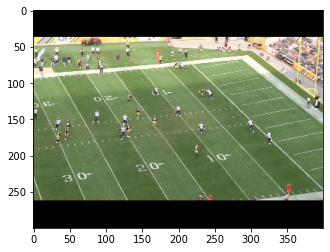

In [19]:
plt.imshow(sample['img'][0].numpy())

In [20]:
raw_pred.shape

TensorShape([1, 37, 50, 5])

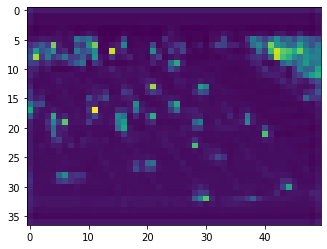

In [21]:
plt.imshow(raw_pred[0][:,:,0])

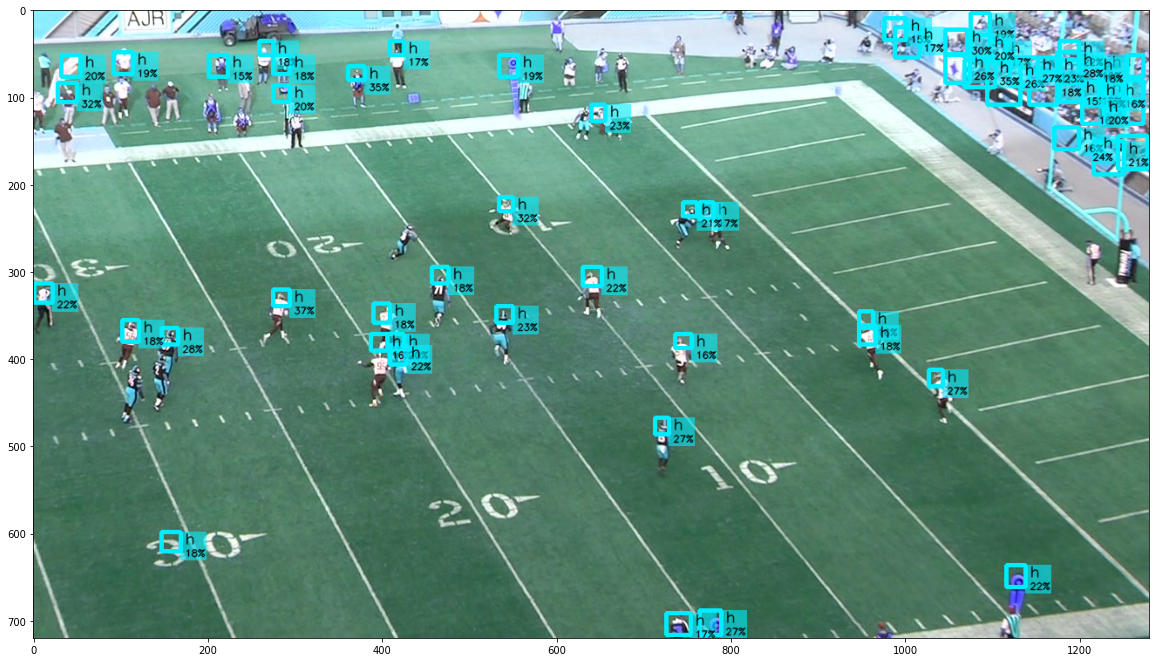

In [37]:
plt.figure(figsize=(20,20))
plt.imshow(draw_bboxes(
    cv2.imread(sample['img_path'][0].numpy().decode('utf-8')),
    bboxes_pred[0]))

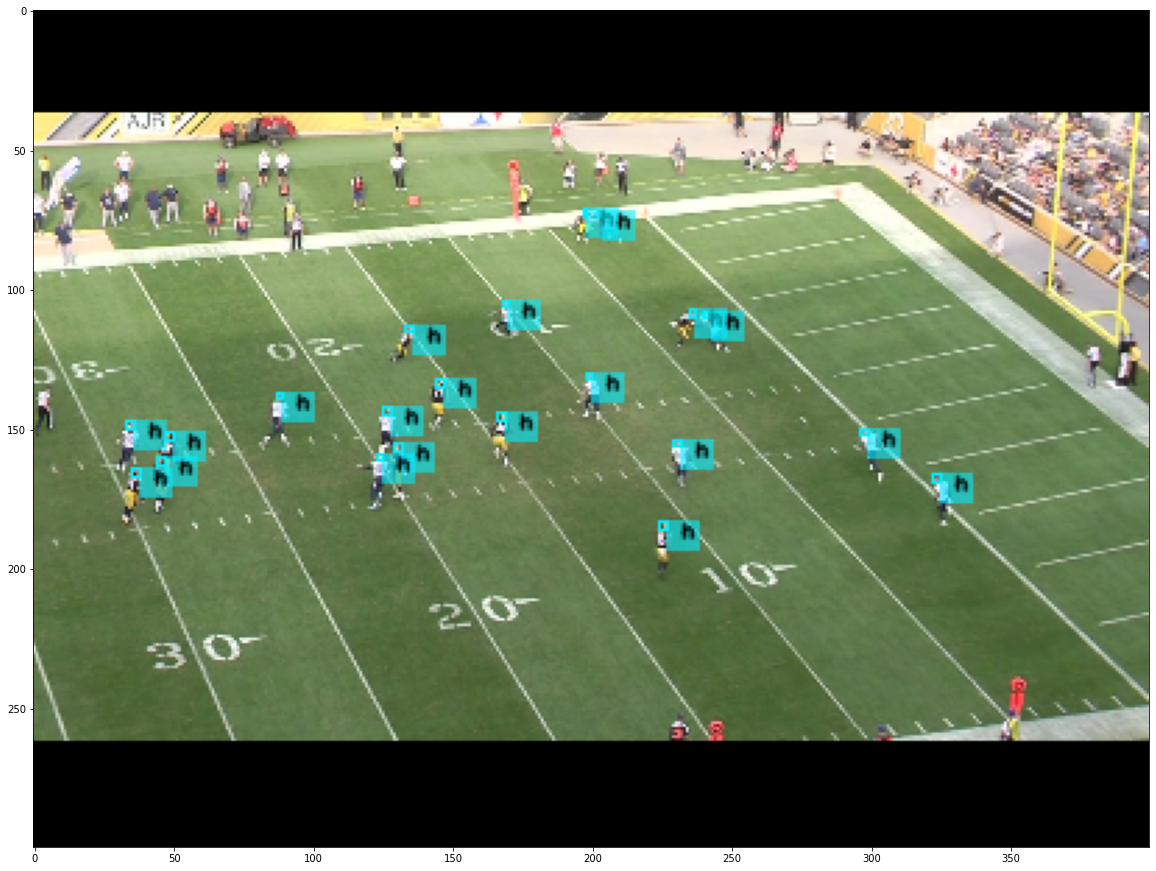

In [36]:
plt.figure(figsize=(20,20))
plt.imshow(draw_bboxes(
    sample['img'][0].numpy(),
    sample['bboxes'][0].numpy()))

In [30]:
sample['img_path'][0].numpy().decode('utf-8')

'/Users/andrewnesterov/Documents/impact_nfl/nfl_impact_detection/data/images/57545_002349_Sideline_frame0739.jpg'

In [32]:
sample['img_path'][0].numpy().decode('utf-8')

'/Users/andrewnesterov/Documents/impact_nfl/nfl_impact_detection/data/images/57545_002349_Sideline_frame0739.jpg'